##  Modeling the Impact of Root Distributions Parameterizations on Total Evapotranspiration in the Reynolds Mountain East catchment using pySUMMA

## 1. Introduction

One part of the Clark et al. (2015) study explored the impact of root distribution on total evapotranspiration (ET) using a SUMMA model for the Reynolds Mountain East catchment. This study looked at sensitivity of different root distribution exponents (0.25, 0.5, 1.0). The sensitivity of evapotranspiration to the distribution of roots, which dictates the capability of plants to access water. 

In this Jupyter Notebook, the pySUMMA library is used to reproduce this analysis. According to the application of different root distribution exponenets (0.25, 0.5, 1.0), the sensitivity of result describes. 
The Results section shows how to use pySUMMA and the Pandas library to reproduce Figure 8(left) from Clark et al. (2015). 

Collectively, this Jupyter Notebook serves as an example of how hydrologic modeling can be conducted directly within a Jupyter Notebook by leveraging the pySUMMA library. 

## 2. Background

### The Transpiration from soil layers available in SUMMA

In [1]:
#import libraries to display equations within the notebook
from IPython.display import display, Math, Latex

\begin{equation*}
(S_{et}^{soil})_j = \frac{(f_{roots})_j(\beta_{v})_j}{\beta_v} \frac{(Q_{trans}^{veg})}{L_{vap}\rho_{liq}(\Delta z)_j} + (S_{evap}^{soil})_j 
\end{equation*}

The transpiration sink term $(S_{et}^{soil})_j$ is computted for a given soil layer $j$.

$Q_{trans}^{veg} (W/m^2)$ : the transpiration flux, $(\beta_{v})_j$ : the soil water stress for the j-th soil layer

$\beta_v$ : the total water availability stress factor, $(f_{roots})_j$ : the fraction of roots in the j-th soil layer

$(\Delta z)_j$ : the depth of the j-th soil layer, $L_{vap} (J/kg), \rho_{liq} (kg/m^3)$ : respectively the latent heat of vaporization and the intrinsic density of liquid water

$(S_{evap}^{soil})_j     (s^{-1})$ : the ground evaporation (only defined for the upper-most soil layer)

The above images are taken from the Stomal Resistance Method section within the manual Structure for Unifying Multiple Modeling Alternatives (SUMMA), Version 1.0: Technical Description (April, 2015).

## 3. Methods

### 1) Study Area

#### The Reynolds Mountain East catchment is located in southwestern Idaho as shown in the figure below.

In [1]:
from ipyleaflet import Map, GeoJSON
import json

In [2]:
m = Map(center=[43.06745, -116.75489], zoom=15)
with open('reynolds_geojson_latlon.geojson') as f:
    data = json.load(f)
g = GeoJSON(data=data)
m.add_layer(g)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### 2) Create pySUMMA Simulation Object

In [12]:
from pysumma.Simulation import Simulation
from pysumma.Plotting import Plotting

In [13]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S = Simulation('/glade/u/home/ydchoi/summaTestCases_2.x/settings/wrrPaperTestCases/figure08/summa_fileManager_riparianAspenPerturbRoots.txt')

### 4) Check root Distribution Exponents

In [14]:
# create a trial parameter object to check root distribution exponents
rootDistExp = Plotting(S.setting_path.filepath+S.para_trial.value)

In [15]:
# open netCDF file
hru_rootDistExp = rootDistExp.open_netcdf()

In [16]:
# check root distribution exponents at each hru
hru_rootDistExp['rootDistExp']

<xarray.DataArray 'rootDistExp' (hru: 5)>
array([1.  , 0.5 , 0.25, 1.  , 1.  ])
Dimensions without coordinates: hru

### 5) Run SUMMA for the different root Distribution Exponents with Develop version of Docker image

In [17]:
# set the simulation start and finish times
S.decision_obj.simulStart.value = "2007-07-01 00:00"
S.decision_obj.simulFinsh.value = "2007-08-20 00:00"

In [18]:
# set SUMMA executable file
S.executable = "/glade/u/home/ydchoi/summa/bin/summa.exe"

In [19]:
# run the model giving the output the suffix "rootDistExp"
results_rootDistExp, output_path = S.execute(run_suffix="rootDistExp_local", run_option = 'local')

## 4. Results

### Recreate the Figure 8 plot from Clark et al., 2015: The total ET Sensitivity with different root Distribution Exponents

In [20]:
from pysumma.Plotting import Plotting
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import pandas as pd
jtplot.figsize(x=10, y=10)

#### 4.1) Create function to calculate Total ET of hour of day from SUMMA output for the period 1 June to 20 August 2007

In [21]:
def calc_total_et(et_output_df):
    # Total Evapotranspiration = Canopy Transpiration + Canopy Evaporation + Ground Evaporation
    # Change unit from kgm-2s-1 to mm/hr (mulpitle 3600)
    total_et_data = (et_output_df['scalarCanopyTranspiration'] + et_output_df['scalarCanopyEvaporation'] + et_output_df['scalarGroundEvaporation'])*3600
    # create dates(X-axis) attribute from ouput netcdf
    dates = total_et_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = total_et_data.data
    # create two dimensional tabular data structure 
    total_et_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_et_df.index = total_et_df.index.round("H")
    # set the time period to display plot 
    total_et_df = total_et_df.loc["2007-06-01":"2007-08-20"]
    # resample data by the average value hourly
    total_et_df_hourly = total_et_df.resample("H").mean()
    # resample data by the average for hour of day
    total_et_by_hour = total_et_df_hourly.groupby(total_et_df_hourly.index.hour).mean()
    return total_et_by_hour

#### 4.2) Get hour of day output of the Parameterization of Root Distributions for the period 1 June to 20 August 2007

In [22]:
rootDistExp_hour = calc_total_et(results_rootDistExp)

In [23]:
# create each hru(1~3) object
rootDistExp_hru_1 = rootDistExp_hour[0]
rootDistExp_hru_2 = rootDistExp_hour[1]
rootDistExp_hru_3 = rootDistExp_hour[2]

#### 4.3) Combine the Parameterization of Root Distributions into a single Pandas Dataframe

In [24]:
# Combine ET for each hru(1~3)
ET_Combine = pd.concat([rootDistExp_hru_1, rootDistExp_hru_2, rootDistExp_hru_3], axis=1)
# add label 
ET_Combine.columns = ['hru_1(Root Exp = 1.0)', 'hru_2(Root Exp = 0.5)', 'hru_3(Root Exp = 0.25)']

In [25]:
ET_Combine

hru_1(Root Exp = 1.0)  hru_2(Root Exp = 0.5)  hru_3(Root Exp = 0.25)
0               -0.022277              -0.018279               -0.015879
1               -0.020909              -0.016702               -0.014371
2               -0.016992              -0.012797               -0.010573
3               -0.014870              -0.010957               -0.008686
4               -0.014346              -0.010680               -0.008605
5               -0.014973              -0.010865               -0.008623
6               -0.014621              -0.010454               -0.008194
7               -0.010745              -0.007707               -0.006015
8               -0.009151              -0.007385               -0.006263
9               -0.008454              -0.006678               -0.005544
10              -0.009924              -0.008200               -0.006943
11              -0.010527              -0.008945               -0.007573
12              -0.013854              -0.012534               -0.011093
13              -0.358140              -0.314361               -0.248358
14              -0.288765              -0.244947               -0.183585
15              -0.252528              -0.217711               -0.165278
16              -0.244457              -0.212174               -0.165492
17              -0.212367              -0.189905               -0.151870
18              -0.172490              -0.158500               -0.133058
19              -0.114469              -0.103439               -0.085725
20              -0.027667              -0.025625               -0.023699
21              -0.027153              -0.023339               -0.020525
22              -0.022692              -0.018144               -0.015445
23              -0.015906              -0.011576               -0.009253

#### 4.4) Add obervation data in Aspen station in Reynolds Mountain East to the plot

In [27]:
# create pySUMMA Plotting Object
Val_eddyFlux = Plotting('/glade/u/home/ydchoi/summaTestCases_2.x/testCases_data/validationData/ReynoldsCreek_eddyFlux.nc')

In [28]:
# read Total Evapotranspiration(LE-wpl) from validation netcdf file
Obs_Evapotranspitaton = Val_eddyFlux.ds['LE-wpl']
# create dates(X-axis) attribute from validation netcdf file
dates = Obs_Evapotranspitaton.coords['time'].data
# Change unit from Wm-2 to mm/hr (1 Wm-2 = 0.0864 MJm-2day-1, 1 MJm-2day-1 = 0.408 mmday-1, 1day = 24h)
data_values = Obs_Evapotranspitaton.data*0.0864*0.408/24
# create two dimensional tabular data structure 
df = pd.DataFrame(data_values, index=dates)
# set the time period to display plot
df_filt = df.loc["2007-06-01":"2007-08-20"]
# select aspen obervation station among three different stations
df_filt.columns = ['-','Observation (aspen)','-']
# resample data by the average for hour of day
df_gp_hr = df_filt.groupby([df_filt.index.hour, df_filt.index.minute]).mean()
# reset index so each row has an hour an minute column
df_gp_hr.reset_index(inplace=True)
# add hour and minute columns for plotting
xvals = df_gp_hr.reset_index()['level_0'] + df_gp_hr.reset_index()['level_1']/60.

#### 4.5) Plotting output of the Parameterization of Root Distributions and observation data

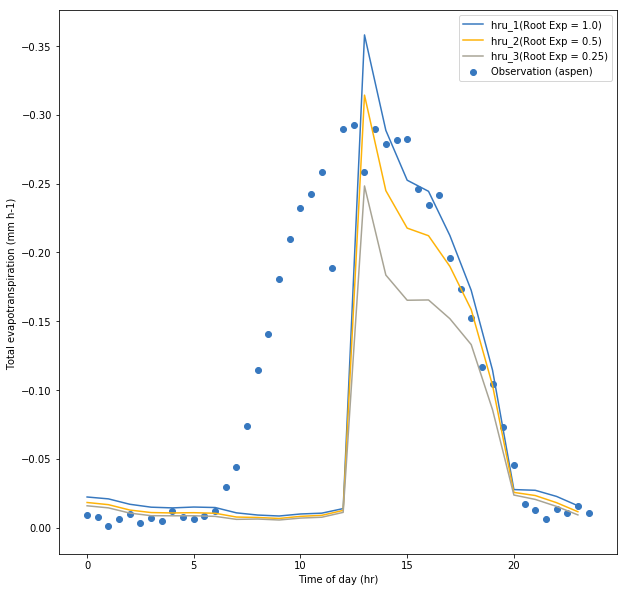

In [29]:
# create plot with the Parameterization of Root Distributions(Root Exp : 1.0, 0.5, 0.25 )
ET_Combine_Graph = ET_Combine.plot()
# invert y axis
ET_Combine_Graph.invert_yaxis()
# plot scatter with x='xvals', y='Observation (aspen)'
ET_Combine_Graph.scatter(xvals, df_gp_hr['Observation (aspen)'])
# add x, y label
ET_Combine_Graph.set(xlabel='Time of day (hr)', ylabel='Total evapotranspiration (mm h-1) ')
# show up the legend
ET_Combine_Graph.legend()

## 5. Discussion

As stated in Clark et al., 2015, the following insights can be gained from this analysis:

* The simulation in Figure 8 illustrates the sensitivity of evapotranspiration to the distribution of roots, which dictates the capability of plants to access water

* The results in Figure 8 demonstrate strong sensitivities the rooting profile. Lower root distribution exponents place more roots near the surface. This makes it more difficult for plants to extract soil water lower in the soil profile, and decreases transpiration